# Group 12 - HUM-274: Milestone 2

In [1]:
from math import fabs
from music21 import midi, note, stream, instrument, meter, duration
from itertools import product
from enum import Enum

# I) Brief Overview

Three distinct procedures enable us to achieve the desired effects.

Firstly, **Brownian motion** encompasses the exposition's mellow beginnings and the story's disruptive element. Indeed, this random process is able to evolve very progressively and naturally, and is thus very much adapted to our slowly changing narrative situation storytellings needs. This is also why Markov chains were overlooked as they would not have that evolutive property we're looking for.

Secondly, we introduce the **L-System**, firstly used for deconstruction of rhythmic regularity and then its reconstruction. It is symbolically important to use one procedure for both tasks, representing the symmetry of the narrative scheme. It's a tool that can achieve chaos, all the while giving enough control and creativity to the user so they can seek convergence, as demonstrated below. This incomplete control lent by L-Systems is more fine-grained than neural networks', which we could have used too, after training them on interesting datasets, at the cost of less creative freedom.

Lastly, a **decision tree based harmonization utility** was programmed for the <em>peripeteia</em>'s second half. We seek harmonic complexity in the descending arc of the narrative scheme to contrast with preceding urban dissonant and ambient sounds. We also seek harmonic richness in the Finale, leading the narration to an epic conclusion. Both tasks can be handled by this utility we have developed, which is meant to be a composer's toolkit with abilities to activate and deactivate chord transition parameters. Therefore, the decision tree and the L-System abstraction cooperate to create both of these subsections.

Let's dive in!

# II) Subsections

### 4) Adding complexity back

The previous part sees the deconstruction of the piece down to urban noises. This part stalls a little bit in this realm
of noise by injecting some rhythmic complexity first through a carefully chosen L-System, which we will reuse later.

Indeed, the L-System abstraction is really powerful as you can easily construct complex phenomena with varying effects.
First, here's our general purpose L-System implementation:

In [2]:
class Rule:
    """
    Encodes L Systems' replacement rules.
    """

    def __init__(self, base: str, replacement: str):
        """
        :param base: string,
        :param replacement: string
        """
        self.base = base
        self.replacement = replacement


class LSystem:
    """
    L System's functionality.
    """

    def __init__(self, *rules):
        """
        An L System = a set of rules

        :param rules: List[Rule]
        """
        self.rules = {}
        [self.rules.update({rule.base: rule.replacement}) for rule in rules]

    def replace(self, base, show_mode: bool = False):
        """
        The brains of an L System, doing the simple task of applying each rule recursively

        :param base: some base string
        :param show_mode: boolean deciding whether to put separating brackets or not between rule applications
        :return: result of applications of all replacement rules on base string
        """
        new_string = ""
        for c in base:
            if c in self.rules:
                if show_mode:
                    new_string += "<"
                new_string += self.rules.get(c)
                if show_mode:
                    new_string += ">"
            else:
                new_string += c
        return new_string

    def run(self, initial: str, nb_iterations: int, show_mode: bool = False):
        """
        Applies the replace method nb_iterations times with base string initial

        :param initial: first base string
        :param nb_iterations: how many times rules replacements should occur
        :param show_mode: boolean deciding whether to put separating brackets or not between rule applications
        :return: last result of rule applications
        """
        string = initial
        for i in range(nb_iterations):
            string = self.replace(string, show_mode)
        return string

This abstraction produces strings which are consequently mapped to musical elements. This is where a human can have
control over the L-System. See, for example, this function mapping L-System sequences to durations.

In [3]:
def sequence_from_string_complex(string: str):
    """
    To use with chars: A, B, C, D, E, F, +, -, [, ]
    A: half note
    B: quarter
    C: eighth
    D: sixteenth
    E: triplet
    F: quintuplet
    +: add previous and next duration
    -: make previous note a rest (value: -1 * duration of rest)
    [: extend previous duration by 50%
    ]: divide previous duration by 2
    :param string: input string
    :return: sequence of durations (floats)
    """

    def char_to_duration(c: str, tb: list):
        if c == 'A':
            tb.append(2)
        elif c == 'B':
            tb.append(1)
        elif c == 'C':
            tb.append(1 / 2)
        elif c == 'D':
            tb.append(1 / 4)
        elif c == 'E':
            tb.append(1 / 3)
        elif c == 'F':
            tb.append(1 / 5)
        elif c == '[':
            if len(tb) > 0:
                tb[-1] = tb[-1] + 0.5 * tb[-1]
        elif c == ']':
            if len(tb) > 0:
                if tb[-1] > float(1.0 / 1024):
                    tb[-1] = tb[-1] / 2
        elif c == '-':
            if len(tb) > 0:
                tb[-1] = -tb[-1]
        return tb[-1]

    def is_duration_char(c: str):
        return c in ['A', 'B', 'C', 'D', 'E', 'F']

    str_arr = [c for c in string]
    tab = []
    while not len(str_arr) == 0:
        nb_chars_read = 1

        if str_arr[0] == '+' and len(str_arr) >= 2:
            nb_chars_read = 2
            if len(tab) > 0 and is_duration_char(str_arr[1]):
                old_read = tab[-1]
                new_read = char_to_duration(str_arr[1], tab)
                new_dur = fabs(old_read) + fabs(new_read)
                if old_read < 0:
                    new_dur = -new_dur
                tab[-2] = new_dur
                tab = tab[:-1]

        else:
            char_to_duration(str_arr[0], tab)

        str_arr = str_arr[nb_chars_read:]  # remove chars read
    return tab

We define some helper functions to play and mix ``music21`` objects, which will be used to their full potential later in the
notebook. For now, we'll modestly use them to play one stream of durations.

In [4]:
def translate(int_note, dur):
    """
    Given an integer value of a note, get a corresponding music21.note object
    :param int_note: integer value of the note
    :param dur: duration of desired note - if negative, interpret as rest
    :return music21.note
    """
    first_char_arr = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    pitch = first_char_arr[int_note % 12] + str(int(2 + int_note / 12))

    if dur < 0:
        return note.Rest(duration=duration.Duration(quarterLength=-dur))
    return note.Note(pitch, duration=duration.Duration(quarterLength=dur))


def combine_voices(length: int, rhythm, *voices, inst=None, time_sig='4/4'):
    """
    Define a voice to be a sequence of integers encoding pitches.
    This function takes multiple voices + an array of note durations (the parameter: rhythm)
    It then superposes all the voices and creates a set of synchronous notes (could be one, two [interval],
    three to nine [chord], or more) and plays these sets consecutively according to the rhythm sequence

    Otherwise said, it adds the same rhythmical durations to each voice, causing them to be superposed

    :param time_sig
    :param inst: list of used instruments
    :param length: common length of voices to consider
    :param rhythm: rhythmic line: sequence of durations
    :param voices: sequences of integers encoding notes
    :return stream of chords
    """

    if inst is None:
        inst = [instrument.Piano()]
    voices = voices[0]
    score = stream.Score()
    score.timeSignature = meter.TimeSignature(time_sig)

    parts = [stream.Part() for _ in range(len(voices))]
    for part_index in range(len(voices)):
        parts[part_index].timeSignature = meter.TimeSignature(time_sig)
        for i in range(length):
            parts[part_index].append(translate(voices[part_index][i], rhythm[i]))

    for i in range(len(parts)):
        parts[i].insert(0, inst[i])
        score.insert(0, parts[i])

    return score


def play(score):
    """Shortcut to play a stream"""
    midi.realtime.StreamPlayer(score).play()


Last but not least, let's put the pieces together! Let's define some rules and see what comes out.

In [5]:
def rules_complex():
    rule_a = Rule("A", "BB[F+E-D+A]FF")
    rule_b = Rule("B", "D[E]-C""D[E]-C")
    rule_c = Rule("C", "CD+C-CF-")
    rule_d = Rule("D", "AE+[D-D]D+ED")
    rule_e = Rule("E", "[E+-]B")
    rule_f = Rule("F", "F+[-B]B[[A]EF]")
    return LSystem(rule_a, rule_b, rule_c, rule_d, rule_e, rule_f)


def initial_complex():
    return "F]AEE-B"


def run_complex_for(n, show_mode=False):
    return rules_complex().run(initial_complex(), n, show_mode)


rhythm = sequence_from_string_complex(run_complex_for(4))
length = int(len(rhythm) / 60)
print(f"{length} notes kept")
score = combine_voices(length, rhythm, [[7 for i in range(length)]], inst=None, time_sig="3/4")

##play(score)

51 notes kept


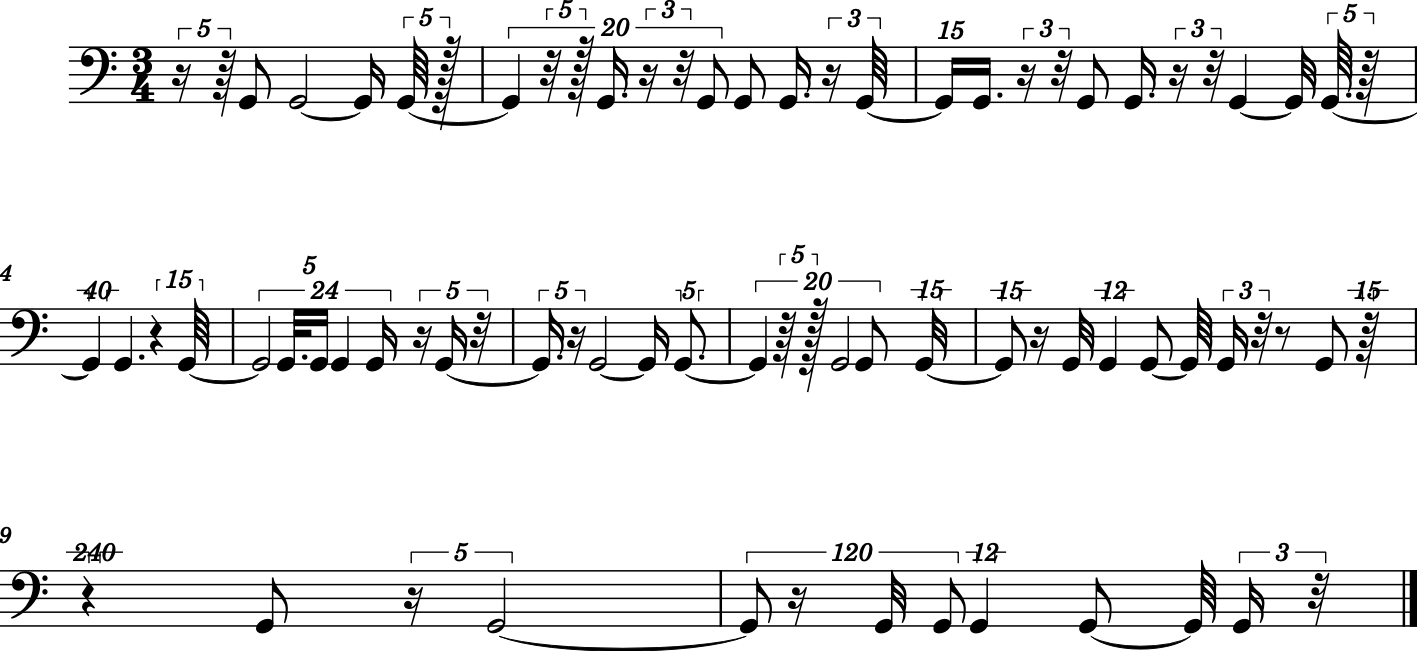

In [6]:
score.show()

This erratic rhythmic pattern creation matches the need for complexity mentioned in Milestone 1, thickening the plot.
Rhythm should be unsettling after the drone section of the composition; our aim is to create contrast, symbolizing dangerous peripeteia.

Our next task is to add melodic values to these durations. This is done through harmonization:

One of the main procedures we use for this fourth part of the composition and the whole piece is the algorithmic harmonization.

As we said in the general description of the piece, this fourth part creates complexity. The harmonization method will contribute with harmonic complexity, as it takes a bass line and a start chord and creates a full composition of 4 voices (bass, tenor, alto, soprano) following some of the most important classic harmonic rules. That rules come from « Treatise on Harmony », by Joaquín Zamacois, which are similar to the ones proposed by Walter Piston in « Harmony ». The code will compute all the different possibilities of transition between chords. Thus, we will move away from the previous simplicity, but we will not fall into a complete chaos, as we follow strict harmonic rules.

The cell below corresponds to a Python file where we implement that algorithmic harmonization. We decided to do the implementation from scratch, i.e. not to use ``music21`` library elements as notes or chords, because we preferred to have an absolute control of the data structures and achieve code efficiency and simplicity.

First, we have some constants and then parameters that we can change in order to have different outcomes (and also for debugging). After that, we create the utilities for the keys and we create the principal data structures for our implementation: the chords and the tree of chords.

More details and clarifications about the implementation are included in the code. We defined some functions, the principal ones are: ``filter_w_rules`` (which applies all the harmonic rules), ``next_chords`` (that computes all the possible next chords from a given one and a bass note) and ``compose`` (which recursively calls the next_chords and fills the chord tree).

In summary, all that code takes as input a bass line and a starting chord and creates a tree of all the possibilities of that harmonisation exercise (a figured bass). Once that code is executed, the following cell defines a method for choosing one among all the possibilities, and the third cell represents the starting parameters and general calls to the functions. The last two little cells show the resulting scores.

Thanks to that algorithmic approach of harmonization, we can use many outcomes to give rise to the fourth part of our piece. We can start with simple degrees, we can end with more uncommon keys and in the meanwhile we can change the parameters, all of this while we increase the audible complexity. We also have to consider the rhythmic complexity provided by the L-System. The bass and the link chords for the modulation between two harmonic blocks will be made by hand.

Moreover, when we were designing the implementation of the algorithmic composition, we decided not to over-complicate our code with chords of sevenths and ninths as we want to do the contrast and the complexity progression between different tonalities. That is, we want changes of colour between different harmonisation blocks rather than inside the same one. 

Besides, we have decided to apply from the L-System rhythms that are not excessively dense (or, at least, not to do so the most of the time), as we tried that for the mock project and it was too repetitive and it did not take advantage of the harmonic depth.

Finally, we will show after the three code cells a pair of outcomes of our algorithmic methods: the first is in G Major and the second one is in A minor.


In [7]:
"""
For the sake of simplicity, we will restrict ourselves to a simple harmonisation, with some assumptions:

Each note of the bass line represents its corresponding grade in the key, hence each chord is in fundamental state,
i.e. there are no inversions.
The chords are only formed with fifths, i.e., we do not use seventh or ninth chords.
"""

###########################################
#               CONSTANTS                 #
###########################################

# NOTES IN THE DIATONIC SCALE
DO = 0
DO_S_RE_F = 1
RE = 2
RE_S_MI_F = 3
MI = 4
FA = 5
FA_S_SOL_F = 6
SOL = 7
SOL_S_LA_F = 8
LA = 9
LA_S_SI_F = 10
SI = 11

# Map from a note (integer) to its corresponding string.
noteOf = {DO: "Do",
          DO_S_RE_F: "Do#/Reb",
          RE: "Re",
          RE_S_MI_F: "Re#/Mib",
          MI: "Mi",
          FA: "Fa",
          FA_S_SOL_F: "Fa#/Solb",
          SOL: "Sol",
          SOL_S_LA_F: "Sol#/Lab",
          LA: "La",
          LA_S_SI_F: "La#/Sib",
          SI: "Si"}

# SCALE DEGREES 0-BASED
TONIC = 0
SUPERTONIC = 1
MEDIANT = 2
SUBDOMINANT = 3
DOMINANT = 4
SUBMEDIANT = 5
LEADING_TONE = 6

# INTERVALS AND ITS CORRESPONDING AMOUNT OF SEMITONES
UNISON = 0
MINOR_THIRD_INTERVAL = 3
MAJOR_THIRD_INTERVAL = 4
PERFECT_FOURTH_INTERVAL = 5
PERFECT_FIFTH_INTERVAL = 7
OCTAVE = 12

###########################################
#          PARAMETERS WE CAN FIT          #
###########################################

EPSILON = 7  # allowed delta between two notes from different adjacent voices when looking for a transition
MAINTAIN_COMMON_NOTES = False  # prioritizes maintaining the common notes when chaining two chords // !!!!!
OVERTAKING_CADENCE = 0  # max. overtaking allowed between two voices when there is a cadence
OVERTAKING_NO_CADENCE = -4  # max. overtaking allowed between two voices when there is not a cadence

RULE_0_ACTIVE = True  # rule 0 : no big overtaking between voices
RULE_1_ACTIVE = True  # rule 1 : no duplication of the leading note
RULE_2_ACTIVE = True  # rule 2 : chords are in (absolute) range
RULE_3_ACTIVE = True  # rule 3 : leading note goes to tonic if grade is V or VII and the following is I, IV or VI
RULE_4_ACTIVE = True  # rule 4 : a note cannot appear more than 2 times in a chord
RULE_5_ACTIVE = True  # rule 5 : the fifth note has to be repeated for VII degree and cannot be repeated otherwise
RULE_6_ACTIVE = True  # rule 6 : all notes of the chord are present
RULE_7_ACTIVE = True  # rule 7 : third duplication (not I, IV, V) and V -> VI (m - M), VI -> V (m)
RULE_8_ACTIVE = True  # rule 8 : fourth augmented interval not allowed
RULE_9_ACTIVE = True  # rule 9 : two consecutive fourths, fifths and octaves are not allowed
RULE_10_ACTIVE = True  # rule 10 : direct fourths, fifths and octaves are not allowed
RULE_11_ACTIVE = True  # rule 11 : leading note and tonic note in the soprano if it is the final cadence

# NOTE RANGES WHERE BASS, TENOR, ALTO AND SOPRANO CAN BE PLACED
MIN_B = DO
MAX_B = DO + 2 * OCTAVE
MIN_T = SOL
MAX_T = SOL + 2 * OCTAVE
MIN_A = SOL + 1 * OCTAVE
MAX_A = MI + 3 * OCTAVE
MIN_S = DO + 2 * OCTAVE
MAX_S = LA + 3 * OCTAVE


###########################################
#            UTILITIES FOR KEYS           #
###########################################

# Creates a new key with one more sharp from the prev_key.
def new_key_sharp(prev_key):
    return [(note + PERFECT_FIFTH_INTERVAL) % 12 for note in prev_key]


# Creates a new key with one more flat from the prev_key.
def new_key_flat(prev_key):
    return [(note + PERFECT_FOURTH_INTERVAL) % 12 for note in prev_key]


# Returns whether a key is major or not.
def is_major(key_min_maj):
    return abs(key_min_maj[MEDIANT] - key_min_maj[TONIC]) == MAJOR_THIRD_INTERVAL


# Enum type which represents keys as lists. From 7 flats to 7 sharps.
class Key(Enum):
    DO_MAJOR = [DO, RE, MI, FA, SOL, LA, SI]
    LA_MINOR = [LA, SI, DO, RE, MI, FA, SOL_S_LA_F]

    # KEYS WITH SHARP :

    SOL_MAJOR = new_key_sharp(DO_MAJOR)
    MI_MINOR = new_key_sharp(LA_MINOR)

    RE_MAJOR = new_key_sharp(SOL_MAJOR)
    SI_MINOR = new_key_sharp(MI_MINOR)

    LA_MAJOR = new_key_sharp(RE_MAJOR)
    FA_S_MINOR = new_key_sharp(SI_MINOR)

    MI_MAJOR = new_key_sharp(LA_MAJOR)
    DO_S_MINOR = new_key_sharp(FA_S_MINOR)

    SI_MAJOR = new_key_sharp(MI_MAJOR)
    SOL_S_MINOR = new_key_sharp(DO_S_MINOR)

    FA_S_MAJOR = new_key_sharp(SI_MAJOR)
    RE_S_MINOR = new_key_sharp(SOL_S_MINOR)

    DO_S_MAJOR = new_key_sharp(FA_S_MAJOR)
    LA_S_MINOR = new_key_sharp(RE_S_MINOR)

    # KEYS WITH FLAT :

    FA_MAJOR = new_key_flat(DO_MAJOR)
    RE_MINOR = new_key_flat(LA_MINOR)

    SI_F_MAJOR = new_key_flat(FA_MAJOR)
    SOL_MINOR = new_key_flat(RE_MINOR)

    MI_F_MAJOR = new_key_flat(SI_F_MAJOR)
    DO_MINOR = new_key_flat(SOL_MINOR)

    LA_F_MAJOR = new_key_flat(MI_F_MAJOR)
    FA_MINOR = new_key_flat(DO_MINOR)

    RE_F_MAJOR = new_key_flat(LA_F_MAJOR)
    SI_F_MINOR = new_key_flat(FA_MINOR)

    SOL_F_MAJOR = new_key_flat(RE_F_MAJOR)
    MI_F_MINOR = new_key_flat(SI_F_MINOR)

    DO_F_MAJOR = new_key_flat(SOL_F_MAJOR)
    LA_F_MINOR = new_key_flat(MI_F_MINOR)


###########################################
#             DATA STRUCTURES             #
###########################################

# Class that represents a chord of three notes which are in the range 0 to 11 (both included).
class SimplifiedChord:
    def __init__(self, fundamental: int, third: int, fifth: int):
        self.fundamental = fundamental % 12
        self.third = third % 12
        self.fifth = fifth % 12

    # Determines whether the (simplified) given note is included in the chord
    def includes(self, note: int):
        new_note = note % 12
        return self.fundamental == new_note or self.third == new_note or self.fifth == new_note


# Class which represents a chord of four notes. The voices are, in order, the bass, the tenor, the alto and the soprano.
class Chord:
    def __init__(self, b: int, t: int, a: int, s: int):
        self.b = b
        self.t = t
        self.a = a
        self.s = s

    # Returns a Chord from a tuple.
    @staticmethod
    def of_tuple(notes):
        if len(notes) == 4:
            return Chord(notes[0], notes[1], notes[2], notes[3])
        else:
            return Chord.empty()

    # Returns the empty Chord.
    @staticmethod
    def empty():
        return Chord(-1, -1, -1, -1)

    # Creates a new Chord with notes in range 0 - 11 and ordered.
    def simplify(self):
        reduced = [self.b % 12, self.t % 12, self.a % 12, self.s % 12]
        return sorted(list({i for i in reduced}))

    # Returns the fundamental of the Chord.
    def fundamental(self):
        return self.b

    # Determines whether the Chord contains the note or not.
    def includes(self, note: int):
        return self.b == note or self.t == note or self.a == note or self.s == note

    # Transforms a Chord into its equivalent list.
    def to_list(self):
        return [self.b, self.t, self.a, self.s]

    # Creates a Chord from a list.
    @staticmethod
    def of(chord_list):
        if len(chord_list) == 4:
            return Chord(chord_list[0], chord_list[1], chord_list[2], chord_list[3])
        else:
            return Chord.empty()

    # Checks whether the notes respect the voice range constraints or not.
    def check_abs_ranges(self):
        abs_range_b = MIN_B <= self.b <= MAX_B
        abs_range_t = MIN_T <= self.t <= MAX_T
        abs_range_a = MIN_A <= self.a <= MAX_A
        abs_range_s = MIN_S <= self.s <= MAX_S

        return abs_range_b and abs_range_t and abs_range_a and abs_range_s

    # Checks if the number of semitones between adjacent voices is correct.
    def check_inter_ranges(self):
        return (abs(self.s - self.a) <= 14) and (abs(self.a - self.t) <= 14) and (abs(self.t - self.b) <= 24)

    # Check if the ranges of the voices are correct from their absolute and inter ranges.
    def check_ranges(self):
        return self.check_abs_ranges() and self.check_inter_ranges()

    # Creates a new SimplifiedChord from a fundamental note and a key.
    @staticmethod
    def simple_of(fundamental: int, key_simple: list):
        new_fundamental = fundamental % 12
        ind_fund = key_simple.index(new_fundamental)
        return SimplifiedChord(key_simple[ind_fund], key_simple[(ind_fund + 2) % 7],
                               key_simple[(ind_fund + 4) % 7])

    def __eq__(self, that):
        if isinstance(that, Chord):
            return self.b == that.b and self.t == that.t and self.a == that.a and self.s == that.s
        else:
            return False

    def __hash__(self):
        return hash((self.b, self.t, self.a, self.s))

    def __str__(self):
        return "Chord (b:{}, t:{}, a:{}, s:{})".format(self.b, self.t, self.a, self.s)


# Class which represents a tree of Chord.
class ChordTree:
    def __init__(self, root: Chord, depth: int):
        self.root = root
        self.depth = depth

    def __str__(self):
        return "\t" * (self.depth - 1) + str(self.root) + " (" + str(self.depth) + ")" + "\n"


# Class that represents a leaf (a form of ChordTree).
# The leaf is formed of a root and has a depth (within its parent ChordTree).
class Leaf(ChordTree):

    def __init__(self, root: Chord, depth: int):
        super().__init__(root, depth)

    # Returns a 1 level as it is a leaf.
    def level(self):
        return 1

    # Returns its total depth within its parent ChordTree.
    def total_depth(self):
        return self.depth

    def __str__(self):
        notes = noteOf[self.root.b % 12] + ", " + noteOf[self.root.t % 12] + ", " \
                + noteOf[self.root.a % 12] + ", " + noteOf[self.root.s % 12]

        return "\t" * (self.depth - 1) + str(self.root) + " (" + notes + ")" + " (" + str(self.depth) + ")" + "\n"


# Class that represents a node (a form of ChordTree). It has a root, a depth (within its parent ChordTree)
# and a list of children (of type ChordTree).
class Node(ChordTree):

    def __init__(self, root: Chord, depth: int, children: list):
        super().__init__(root, depth)
        self.children = children

    # Adds a child to the node.
    def add_child(self, child):
        self.children.append(child)

    # Adds a list of children to the node.
    def add_children(self, children):
        self.children.extend(children)

    # Returns the total number of leaves the node contains as a ChordTree.
    def level(self):
        children_count = 0
        for child in self.children:
            children_count += child.level()
        return children_count

    # Returns the largest total depth of its children as a ChordTree.
    def total_depth(self):
        max_depth = 1
        for child in self.children:
            child_total_depth = child.total_depth()
            if child_total_depth > max_depth:
                max_depth = child_total_depth
        return max_depth

    def __str__(self):
        notes = noteOf[self.root.b % 12] + ", " + noteOf[self.root.t % 12] + ", " \
                + noteOf[self.root.a % 12] + ", " + noteOf[self.root.s % 12]
        ret = "\t" * (self.depth - 1) + str(self.root) + " (" + notes + ")" + " (" + str(self.depth) + ")" + "\n"

        for child in self.children:
            ret += str(child)
        return ret


# Class that represents a empty node (a form of ChordTree). It has a depth (within its parent ChordTree).
class Empty(ChordTree):
    def __init__(self, depth: int):
        super().__init__(Chord.empty(), depth)

    def __str__(self):
        print("Empty")


###########################################
#          HARMONISATION METHODS          #
###########################################

# Auxiliary method which returns the cartesian product of chords (as lists) for all the simple_options.
def all_options(simple_options):
    return {i for i in product(*simple_options)}


# Auxiliary method that returns a range (of notes) within the epsilon value.
def all_in_epsilon(note):
    return range(max(0, note - EPSILON), note + EPSILON + 1)


# Auxiliary method that completes and returns all the possible transitions between the current chord
# and the next chord, both represented by a list.
# For the notes of the next_chord that are not defined, it creates a list with all the possible values.
# After that, it computes and returns all the different possibilities of chords.
def complete_transition(current_chord_list, next_chord_list, next_simple_chord: SimplifiedChord):
    simple_options = []

    for i, note in enumerate(next_chord_list):

        if note == -1:
            # adds the list for the notes within the range and filters it by the notes included in the next chord
            simple_options.append(list(filter(lambda x: next_simple_chord.includes(x),
                                              list(all_in_epsilon(current_chord_list[i])))))
        else:
            simple_options.append([note])  # the note is already defined

    return all_options(simple_options)  # computes all the options from the simple list (of length 4) of lists


# From current_chord_list (the list that represents the current chord), options (the set of all the possible chords
# chain with the current chord), next_next_degree (the note that represents the degree two positions ahead, -1 if there
# is not), is_final_cadence (boolean that determines if the next_chord is the final chord of a cadence) and
# key_rules_input (the key).
#
# This method sequentially filters the set of all possible options following the more important harmonic rules.
# The different rules can be deactivated independently thanks to the corresponding constants.
def filter_w_rules(current_chord_list, options, next_next_degree, is_final_cadence, key_rules_input):
    key_degrees = key_rules_input.value

    # The temporary set that changes with respect to the rules
    temp = options.copy()
    ##############################################
    # RULE 0 : NO BIG OVERTAKING BETWEEN VOICES
    temp0 = set()
    for next_chord in temp:

        # Intervals between adjacent voices
        b_t_interval = next_chord[1] - next_chord[0]
        t_a_interval = next_chord[2] - next_chord[1]
        a_s_interval = next_chord[3] - next_chord[2]

        # The allowed overtaking between voices depends on whether there is a cadence or not
        not_big_overtake_b_t = b_t_interval >= OVERTAKING_NO_CADENCE if is_final_cadence else b_t_interval >= OVERTAKING_CADENCE
        not_big_overtake_t_a = t_a_interval >= OVERTAKING_NO_CADENCE if is_final_cadence else t_a_interval >= OVERTAKING_CADENCE
        not_big_overtake_a_s = a_s_interval >= OVERTAKING_NO_CADENCE if is_final_cadence else a_s_interval >= OVERTAKING_CADENCE

        if not_big_overtake_b_t and not_big_overtake_t_a and not_big_overtake_a_s:
            temp0.add(next_chord)
    temp = temp0 if RULE_0_ACTIVE else temp

    ##############################################
    # RULE 1 : NO DUPLICATION OF THE LEADING NOTE
    temp1 = set()
    for next_chord in temp:
        ack = 0
        for note in next_chord:
            if note % 12 == key_degrees[LEADING_TONE]:
                ack += 1
        if 0 <= ack < 2:
            temp1.add(next_chord)
    temp = temp1 if RULE_1_ACTIVE else temp

    ##############################################
    # RULE 2 : CHORDS RESPECT CORRECT RANGES
    temp2 = set()
    for next_chord in temp:
        if Chord.of_tuple(next_chord).check_ranges():
            temp2.add(next_chord)
    temp = temp2 if RULE_2_ACTIVE else temp

    ####################################################################
    # RULE 3 : LEADING NOTE GOES TO TONIC IF CURRENT GRADE IS III, V OR VII
    #          AND THE FOLLOWING IS I, IV OR VI
    temp3 = set()
    for next_chord in temp:

        prev_fund = Chord.simple_of(current_chord_list[0], key_degrees).fundamental
        current_fund = Chord.simple_of(next_chord[0], key_degrees).fundamental

        # Determines whether the leading notes is considered active (need to resolve)
        leading_active = (prev_fund == key_degrees[DOMINANT] or prev_fund == key_degrees[LEADING_TONE] or prev_fund ==
                          key_degrees[MEDIANT]) \
                         and (current_fund == key_degrees[TONIC] or current_fund == key_degrees[SUBDOMINANT]
                              or current_fund == key_degrees[SUBMEDIANT])

        for i, curr_note in enumerate(current_chord_list):
            if not leading_active or \
                    (curr_note % 12 == key_degrees[LEADING_TONE] and next_chord[i] % 12 == key_degrees[TONIC]
                     and leading_active):
                temp3.add(next_chord)
    temp = temp3 if RULE_3_ACTIVE else temp

    ##################################################################
    # RULE 4 : A NOTE CANNOT APPEAR MORE THAT 2 TIMES IN A SAME CHORD
    temp4 = set()
    for next_chord in temp:
        simple_notes_list = list(map(lambda x: x % 12, list(next_chord)))
        correct_dupl = True

        for note in simple_notes_list:
            if simple_notes_list.count(note) > 2:
                correct_dupl = False

        if correct_dupl:
            temp4.add(next_chord)
    temp = temp4 if RULE_4_ACTIVE else temp

    #############################################################################################
    # RULE 5 : THE FIFTH NOTE HAS TO BE REPEATED FOR VII DEGREE AND CANNOT BE REPEATED OTHERWISE
    temp5 = set()
    for next_chord in temp:
        fund = Chord.simple_of(next_chord[0], key_degrees).fundamental
        fifth = Chord.simple_of(next_chord[0], key_degrees).fifth
        simple_notes_list = list(map(lambda x: x % 12, list(next_chord)))

        if fund % 12 == key_degrees[LEADING_TONE]:
            if simple_notes_list.count(fifth) == 2:
                temp5.add(next_chord)
        elif simple_notes_list.count(fifth) < 2:
            temp5.add(next_chord)
    temp = temp5 if RULE_5_ACTIVE else temp

    ##############################################
    # RULE 6 : ALL NOTES OF THE CHORD ARE PRESENT
    temp6 = set()
    for next_chord in temp:
        simple_next_chord = Chord.simple_of(next_chord[0], key_degrees)
        simple_notes_list = list(map(lambda x: x % 12, list(next_chord)))

        if simple_next_chord.fundamental in simple_notes_list and simple_next_chord.third in simple_notes_list \
                and simple_next_chord.fifth in simple_notes_list:
            temp6.add(next_chord)
    temp = temp6 if RULE_6_ACTIVE else temp

    ########################################################################################################
    # RULE 7 : THIRD DUPLICATION IS AUTHORISED WHEN THE DEGREE IS NOT I, IV AND V; AND IS MANDATORY WHEN
    #               V -> VI chaining in major and minor tonalities (3rd duplicated in VI)
    #               VI -> V chaining in minor tonality (3rd duplicated in VI)
    #               VII -> I (already implemented because of the 1st and 5st rules, 3rd dup. in VII)
    temp7 = set()
    for next_chord in temp:
        prev_fund = Chord.simple_of(current_chord_list[0], key_degrees).fundamental
        next_fund = Chord.simple_of(next_chord[0], key_degrees).fundamental
        third = Chord.simple_of(next_chord[0], key_degrees).third
        simple_notes_list = list(map(lambda x: x % 12, list(next_chord)))

        third_two_times = simple_notes_list.count(third) == 2

        # Third duplication not recommended
        third_not_recom = next_fund == key_degrees[TONIC] or next_fund == key_degrees[SUBDOMINANT] \
                          or next_fund == key_degrees[DOMINANT]

        # V -> VI chaining in major and minor tonalities (3rd dup. in VI)
        v_vi = prev_fund == key_degrees[DOMINANT] and next_fund == key_degrees[SUBMEDIANT]

        # VI -> V chaining in minor tonality (3rd dup. in VI)
        vi_v_minor = next_fund == key_degrees[SUBMEDIANT] and \
                     next_next_degree == key_degrees[DOMINANT] and not is_major(key_degrees)

        mandatory_third = v_vi or vi_v_minor

        if (mandatory_third and third_two_times) or (not mandatory_third and not (third_not_recom and third_two_times)):
            temp7.add(next_chord)
    temp = temp7 if RULE_7_ACTIVE else temp

    #################################################
    # RULE 8 : FOURTH AUGMENTED INTERVAL NOT ALLOWED
    temp8 = set()
    for next_chord in temp:

        has_augm_interval = False
        for i, current_note_i in enumerate(current_chord_list):

            # Current note (and next note) are the leading note
            current_note_leading = current_note_i % 12 == key_degrees[LEADING_TONE]
            next_note_leading = next_chord[i] % 12 == key_degrees[LEADING_TONE]

            # Ascending augmented forth interval
            aug_forth_asc = current_note_i % 12 == key_degrees[SUBDOMINANT] and \
                            next_note_leading and \
                            next_chord[i] - current_note_i == 6

            # Descending augmented forth interval
            aug_forth_des = current_note_leading and \
                            next_chord[i] % 12 == key_degrees[SUBDOMINANT] and \
                            current_note_i - next_chord[i] == 6

            # Ascending augmented second interval
            aug_second_asc = current_note_i % 12 == key_degrees[SUBMEDIANT] and \
                             next_note_leading and \
                             next_chord[i] - current_note_i == 3

            # Descending augmented second interval
            aug_second_des = current_note_leading and \
                             next_chord[i] % 12 == key_degrees[SUBDOMINANT] and \
                             current_note_i - next_chord[i] == 3

            # Ascending augmented fifth interval
            aug_fifth_asc = current_note_i % 12 == key_degrees[MEDIANT] and \
                            next_note_leading and \
                            next_chord[i] - current_note_i == 8

            # Descending augmented fifth interval
            aug_fifth_des = current_note_leading and \
                            next_chord[i] % 12 == key_degrees[MEDIANT] and \
                            current_note_i - next_chord[i] == 8

            # If the key is major, augmented intervals can only be fourths
            if is_major(key_degrees):
                if aug_forth_asc or aug_forth_des:
                    has_augm_interval = True

            # If the key is minor, augmented intervals can be fourths, fifths and seconds
            else:
                if aug_forth_asc or aug_forth_des or aug_second_asc or aug_second_des \
                        or aug_fifth_asc or aug_fifth_des:
                    has_augm_interval = True

        if not has_augm_interval:
            temp8.add(next_chord)
    temp = temp8 if RULE_8_ACTIVE else temp

    #########################################################################
    # RULE 9 : TWO CONSECUTIVE FOURTHS, FIFTHS AND OCTAVES ARE NOT ALLOWED
    temp9 = set()
    for next_chord in temp:
        interval_problem = False

        # Compares for the not allowed consecutive intervals between the two chords
        # for all the possible pairs of voices (voice i and a higher voice j)
        for i, note_current_i in enumerate(current_chord_list):
            for j in range(i, 4):
                if i != j:
                    # There is no common note
                    mov = current_chord_list[j] != next_chord[j] or note_current_i != next_chord[i]

                    interval_current = (current_chord_list[j] - note_current_i) % 12
                    interval_next = (next_chord[j] - next_chord[i]) % 12
                    if interval_current == interval_next and mov and \
                            (interval_current == UNISON or interval_current == PERFECT_FOURTH_INTERVAL or
                             interval_current == PERFECT_FIFTH_INTERVAL):
                        interval_problem = True
        if not interval_problem:
            temp9.add(next_chord)
    temp = temp9 if RULE_9_ACTIVE else temp

    #########################################################################
    # RULE 10 : DIRECT FOURTHS, FIFTHS AND OCTAVES ARE NOT ALLOWED
    temp10 = set()
    for next_chord in temp:
        interval_problem = False

        # Compares for the not allowed direct intervals between the two chords
        # for all the possible pairs of voices (voice i and a higher voice j)
        for i, note_current_i in enumerate(current_chord_list):
            for j in range(i, 4):
                if i != j:

                    # An interval is considered direct if both voices change in the same direction
                    # and both for more of a tone
                    interval_next = (next_chord[j] - next_chord[i]) % 12
                    change_chords_i = next_chord[i] - note_current_i
                    change_chords_j = next_chord[j] - current_chord_list[j]

                    if ((change_chords_i > 2 and change_chords_j > 2) or (
                            change_chords_i < -2 and change_chords_j < -2)) \
                            and (interval_next == UNISON or interval_next == PERFECT_FOURTH_INTERVAL
                                 or interval_next == PERFECT_FIFTH_INTERVAL):
                        interval_problem = True

        if not interval_problem:
            temp10.add(next_chord)
    temp = temp10 if RULE_10_ACTIVE else temp

    ###################################################################################
    # RULE 11 : LEADING NOTE AND TONIC NOTE IN THE SOPRANO IF IT IS THE FINAL CADENCE
    temp11 = set()
    if (not is_final_cadence) or current_chord_list[0] % 12 == key_degrees[LEADING_TONE]:
        temp11 = temp10
    else:
        for next_chord in temp:
            if current_chord_list[3] % 12 == key_degrees[LEADING_TONE] and next_chord[3] % 12 == key_degrees[TONIC]:
                temp11.add(next_chord)
    temp = temp11 if RULE_11_ACTIVE else temp

    return temp


# Dictionary that includes transitions from a chord and a the next bass note to all the possible next chords
transition = {}


# Method that from a current_chord, the next_note of the bass, the next_next_note of the bass,
# a boolean is_final_cadence and a key computes all the possible next chords.
def next_chords(current_chord: Chord, next_note: int, next_next_note: int, is_final_cadence: bool, key_for_chords: Key):
    global transition

    options = transition.get((current_chord, next_note))

    # If the transition is already computed, it uses it and does not again the computation (dynamic programming)
    if options is not None and not is_final_cadence:
        return options

    else:
        options = set()

        current_chord_list = current_chord.to_list()
        # Already copies the bass note
        next_chord_list = [next_note]
        next_simple_chord = Chord.simple_of(next_note, key_for_chords.value)

        # If the constant MAINTAIN_COMMON_NOTES is true, we keep the common notes in the following chord if possible
        # For the undetermined notes, it adds -1
        if MAINTAIN_COMMON_NOTES:
            if current_chord.fundamental() == next_note:
                options.add(tuple(current_chord.to_list()))
            else:
                for note in current_chord_list[1:]:
                    if next_simple_chord.includes(note) and note % 12 != key_for_chords.value[LEADING_TONE]:
                        next_chord_list.append(note)
                    else:
                        next_chord_list.append(-1)
        else:
            next_chord_list = [next_note, -1, -1, -1]

        # Computes of the possible options for the next chord thanks to the filter_w_rules method
        options = filter_w_rules(current_chord_list,
                                 complete_transition(current_chord_list, next_chord_list, next_simple_chord),
                                 next_next_note,
                                 is_final_cadence,
                                 key_for_chords)

        if is_final_cadence:
            # Adds the current transition to the global dictionary
            transition[(current_chord, next_note)] = tuple(opt for opt in options)
            return transition[(current_chord, next_note)]
        else:
            return tuple(opt for opt in options)


# Recursive method that from an initial_chord, a bass_line, a ChordTree (prev_chord_tree), a tonality (tonality_compose)
# and a boolean (prev_cadence, which indicates that the previous chord started a cadence)
# computes algorithmically the composition (computes all the possible harmonizations) and inserts it into the tree.
# A node (or a leaf) of the chord tree keeps track of its previous chord.
def compose(initial_chord, bass_line, prev_chord_tree, prev_cadence, tonality_compose):
    ton_value = tonality_compose.value
    next_cadence = False

    if len(bass_line) > 1:
        if len(bass_line) == 2:
            next_cadence = bass_line[0] % 12 == ton_value[DOMINANT] or bass_line[0] % 12 == ton_value[LEADING_TONE] \
                           or (bass_line[0] % 12 == ton_value[MEDIANT])

        # All the possible next chords from the current chord
        list_next_chords = next_chords(initial_chord, bass_line[0], bass_line[1], prev_cadence, tonality_compose)

        for chord in list_next_chords:
            chord_type = Chord(chord[0], chord[1], chord[2], chord[3])
            node = Node(chord_type, prev_chord_tree.depth + 1, [])
            # Adds the next chord to a node and continues the composition from that chord
            prev_chord_tree.add_child(node)
            compose(chord_type, bass_line[1:], node, next_cadence, tonality_compose)

    elif len(bass_line) == 1:
        # Notifies next_chords that this is the final cadence
        list_next_chords = next_chords(initial_chord, bass_line[0], -1, prev_cadence, tonality_compose)

        for chord in list_next_chords:
            chord_type = Chord(chord[0], chord[1], chord[2], chord[3])
            # As it is the final chord, creates a leaf instead of a node
            leaf = Leaf(chord_type, prev_chord_tree.depth + 1)
            prev_chord_tree.add_child(leaf)

In [8]:
import random

def to_arrays(voices):
    """
    :param voices: list of chords
    """
    bass = []
    tenor = []
    alto = []
    soprano = []

    for chord in voices:
        bass.append(chord.b)
        tenor.append(chord.t)
        alto.append(chord.a)
        soprano.append(chord.s)

    return [bass, tenor, alto, soprano]

def combine_voices_harm(length: int, rhythm, *voices, inst=None, time_sig='4/4'):
    """
    :param length: common length of voices to consider
    :param voices: sequences of integers encoding notes
    :param inst: instruments
    :param time_sig: time signature
    :return stream of chords
    """

    voices = voices[0]
    if inst is None:
        inst = [instrument.BrassInstrument() if i % 2 == 0 else instrument.Piano() for i in range(len(voices))]
    score = stream.Score(timeSignature=time_sig)

    parts = [stream.Part() for _ in range(len(voices))]
    for part_index in range(len(voices)):
        for i in range(length):
            parts[part_index].append(translate(voices[part_index][i], 1))

    for i in reversed(range(len(parts))):
        parts[i].insert(0, inst[i])
        score.insert(0, parts[i])

    return score


def select_path_in_tree_harm(length: int, composition_tree: Node):
    curr_node = composition_tree
    path = [curr_node.root]

    for i in range(length):

        if isinstance(curr_node, Node):
            list_index = list(range(0, len(curr_node.children)))
            random.shuffle(list_index)

            index = 0
            index_elem = list_index[index]

            while index < len(list_index) - 1 and curr_node.children[index_elem].total_depth() != length:
                index += 1
                index_elem = list_index[index]

            curr_node = curr_node.children[index_elem]
            path.append(curr_node.root)

    return path

In [9]:
bass_do_major = [DO, FA, SOL, SI, DO + OCTAVE, FA, LA, FA, SOL, SI, DO + OCTAVE, FA, SOL, DO, SOL, DO]
bass_sol_major = [note + PERFECT_FIFTH_INTERVAL for note in bass_do_major]
bass_la_minor = [LA, RE, MI, SOL_S_LA_F, LA, RE, FA, RE, MI, SOL_S_LA_F, LA, RE, MI, LA, MI, LA]

start_chord_sol_major = Chord(SOL, SI + 1 * OCTAVE, SOL + 2 * OCTAVE, RE + 3 * OCTAVE)
start_chord_la_minor = Chord(LA, DO + 2 * OCTAVE, LA + 2 * OCTAVE, MI + 3 * OCTAVE)


def create_composition(key, start_chord, bass, ):
    voices = [[], [], [], []]
    composition_tree = Node(start_chord, 1, [])

    compose(start_chord, bass[1:], composition_tree, False, key)
    # print(composition_tree)
    print("composition_tree's level (total number of different compositions) : " + str(composition_tree.level()))

    path = select_path_in_tree_harm(len(bass), composition_tree)
    path = to_arrays(path)[0:len(path)]
    for i in range(4):
        voices[i].extend(path[i])

    parts = combine_voices_harm(len(voices[0]), [], voices,
                                inst=[instrument.Piano(), instrument.Piano(), instrument.Piano(), instrument.Piano()])

    parts.show()
    play(parts)

Chord (b:7, t:23, a:31, s:38) (Sol, Si, Sol, Re) (1)
	Chord (b:12, t:28, a:31, s:36) (Do, Mi, Sol, Do) (2)
		Chord (b:14, t:26, a:30, s:33) (Re, Re, Fa#/Solb, La) (3)
			Chord (b:18, t:24, a:33, s:36) (Fa#/Solb, Do, La, Do) (4)
				Chord (b:19, t:31, a:35, s:38) (Sol, Sol, Si, Re) (5)
					Chord (b:12, t:31, a:36, s:40) (Do, Sol, Do, Mi) (6)
						Chord (b:16, t:31, a:35, s:40) (Mi, Sol, Si, Mi) (7)
							Chord (b:12, t:28, a:36, s:43) (Do, Mi, Do, Sol) (8)
								Chord (b:14, t:26, a:33, s:42) (Re, Re, La, Fa#/Solb) (9)
									Chord (b:18, t:24, a:36, s:45) (Fa#/Solb, Do, Do, La) (10)
										Chord (b:19, t:31, a:35, s:38) (Sol, Sol, Si, Re) (11)
											Chord (b:12, t:31, a:36, s:40) (Do, Sol, Do, Mi) (12)
												Chord (b:14, t:30, a:33, s:38) (Re, Fa#/Solb, La, Re) (13)
													Chord (b:7, t:31, a:35, s:38) (Sol, Sol, Si, Re) (14)
														Chord (b:14, t:30, a:33, s:38) (Re, Fa#/Solb, La, Re) (15)
										Chord (b:19, t:26, a:35, s:43) (Sol, Re, Si, Sol) (1

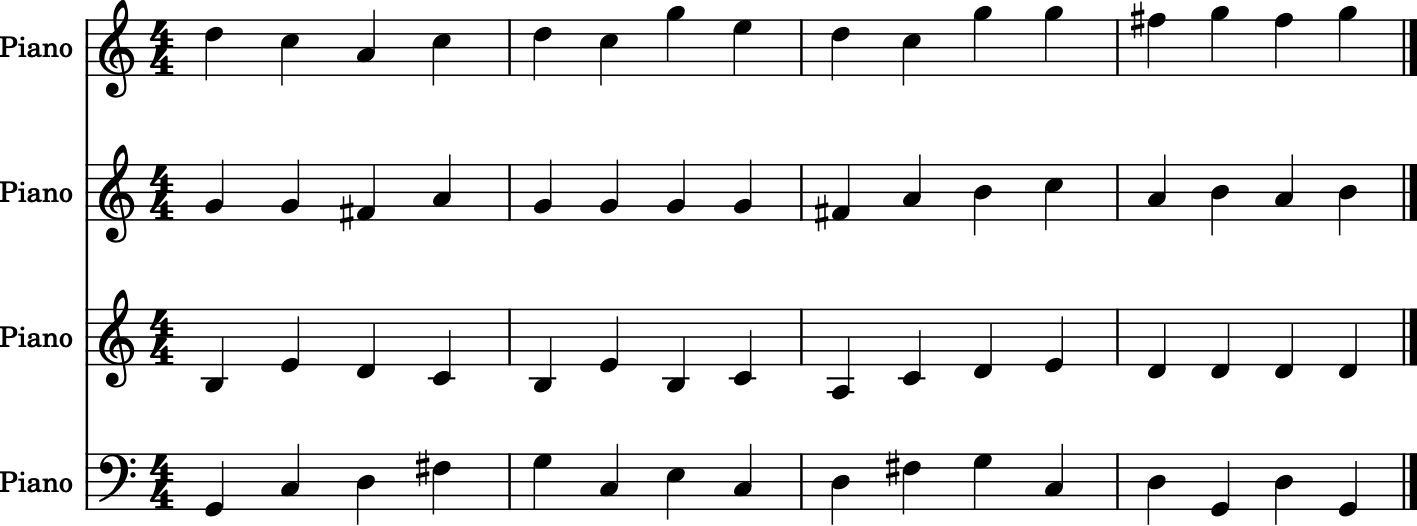

pygame 2.0.1 (SDL 2.0.14, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [10]:
create_composition(Key.SOL_MAJOR, start_chord_sol_major, bass_sol_major)

Chord (b:9, t:24, a:33, s:40) (La, Do, La, Mi) (1)
	Chord (b:2, t:26, a:33, s:41) (Re, Re, La, Fa) (2)
		Chord (b:4, t:23, a:32, s:40) (Mi, Si, Sol#/Lab, Mi) (3)
			Chord (b:8, t:26, a:35, s:38) (Sol#/Lab, Re, Si, Re) (4)
				Chord (b:9, t:28, a:36, s:45) (La, Mi, Do, La) (5)
				Chord (b:9, t:28, a:33, s:36) (La, Mi, La, Do) (5)
					Chord (b:2, t:26, a:33, s:41) (Re, Re, La, Fa) (6)
						Chord (b:5, t:24, a:33, s:41) (Fa, Do, La, Fa) (7)
							Chord (b:2, t:26, a:33, s:41) (Re, Re, La, Fa) (8)
								Chord (b:4, t:23, a:32, s:40) (Mi, Si, Sol#/Lab, Mi) (9)
									Chord (b:8, t:26, a:35, s:38) (Sol#/Lab, Re, Si, Re) (10)
										Chord (b:9, t:28, a:36, s:45) (La, Mi, Do, La) (11)
										Chord (b:9, t:28, a:33, s:36) (La, Mi, La, Do) (11)
											Chord (b:2, t:26, a:33, s:41) (Re, Re, La, Fa) (12)
												Chord (b:4, t:23, a:32, s:40) (Mi, Si, Sol#/Lab, Mi) (13)
													Chord (b:9, t:24, a:33, s:40) (La, Do, La, Mi) (14)
														Chord (b:4, t:23, a:32, s:40)

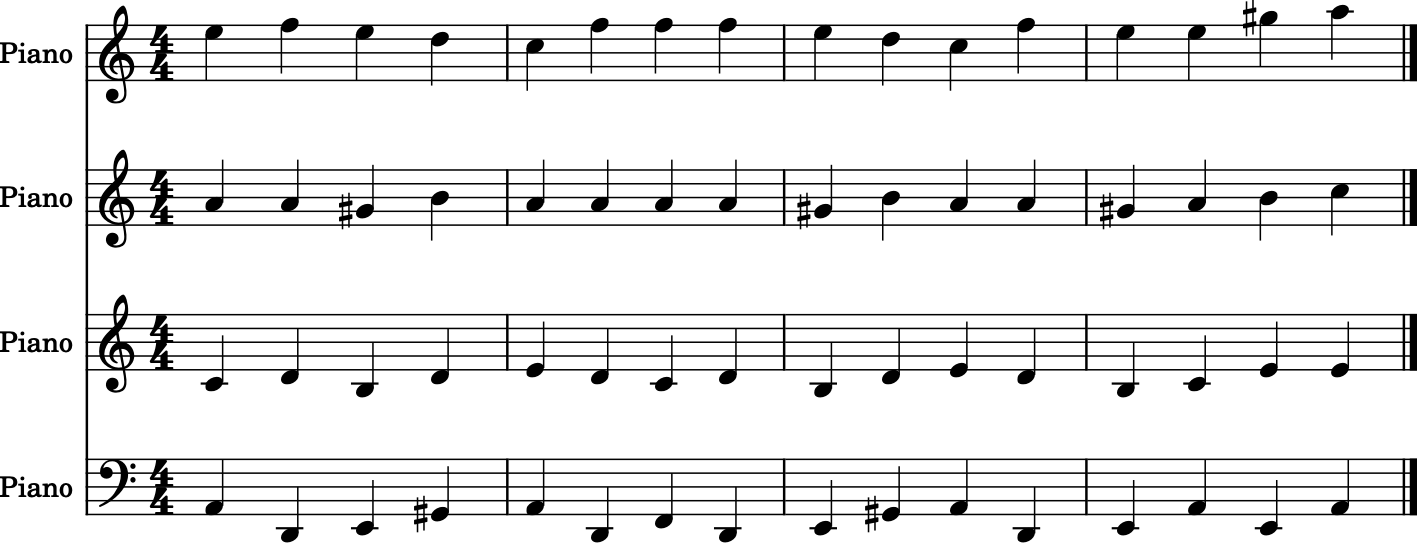

In [11]:
create_composition(Key.LA_MINOR, start_chord_la_minor, bass_la_minor)

### 5) Convergence after chaos
The second to last step of the composition sees a reconvergence to the main theme. Rhythm and melody converge separately
to a theme resembling that of the *Boléro*.

Let's start with rhythm. We need to find an appropriate L-System and a string to durations function. In the previous
section, the artistic choice of complex chaos made it simple to come up with a berzerk L-System that generates
random-sounding notes. The goal is reversed this time: *Boléro*'s main theme is very simple and very repetitive.

In [12]:
def rules_bolero():
    """
    Converge to the Bolero snare drum part: A B A C
    where A = the common first half of the two measures 
              (one eighth note + 3 sixteenths)
          B = A + 2 eighth notes, the second half of the 
              first measure
          C = A + 6 sixteenth notes, the second half of the
              second measure
    """
    return LSystem(
        Rule("A", "ESSS"),
        Rule("B", "ESSSEE"),
        Rule("C", "ESSSSSSSSSZ"),
        Rule("E", "E"),
        Rule("S", "S"),
        Rule("T", "S"),
        Rule("W", "STSTSTTSSE"),
        Rule("X", "WYTTAYYESSYZ"),
        Rule("Y", "BATTWBWTTTTSTTA"),
        Rule("Z", "ABAC")
    )


def initial_bolero():
    return "YWWX"


def run_bolero_for(n, show_mode=False):
    return rules_bolero().run(initial_bolero(), n, show_mode)


def sequence_from_string_bolero(string: str):
    """
    To use with chars in chars_bolero
    Notes with rhythmical values:

    E: eight note
    S: sixteenth note
    T: 32nd note
    
    A: triplet
    B: two triplets
    C: dotted eight note
    
    W: quarter note rest
    X: quintuplet
    Y: two quintuplets
    Z: eight note rest

    :param string: input string
    :return: sequence of durations (floats)
    """
    note_durations = {
        "E": 1 / 2,
        "S": 1 / 4,
        "T": 1 / 8,
        
        "A": 1/3,
        "B": 2/3,
        "C": 3/4,
        
        "W": -1/4,
        "X": 1/5,
        "Y": 2/5,
        "Z": -1/2
    }

    return [note_durations.get(c) for c in string]

Let's see what this sequence looks like and confirms that it actually converges to *Boléro*'s snare drum part:

In [13]:
bolero_rhythm = run_bolero_for(3, True)
print(f"end of the sequence: {bolero_rhythm[-60:]}")

beginning of the sequence: <<<E><S><S><S><E><E>><<E><S><S><S>><<S>><<S>><<S><S><S><S><S
end of the sequence: S><S><S><S><S><S><ESSS>><<ESSS><ESSSEE><ESSS><ESSSSSSSSSZ>>>


The very end of the sequence is indeed: <<ESSS><ESSSEE><ESSS><ESSSSSSSSSZ>> == <ABAC>, which is the Boléro's main rhythm: recall that E is an eighth note and S a sixteenth. Z = <ABAC> simply ensures continuity of the rhythm at the next cycle. Convergence is confirmed!

Now let's see and hear what it sounds like. Play the next cell to listen; do note that the generated transition should be shorter than this sample in the final composition.

In [14]:
bolero_rhythm = sequence_from_string_bolero(run_bolero_for(3, False))
length = int(len(bolero_rhythm))
bolero_score = combine_voices(length, bolero_rhythm, [[7 for i in range(length)]], inst=[instrument.Woodblock()], time_sig="3/4")
play(bolero_score)

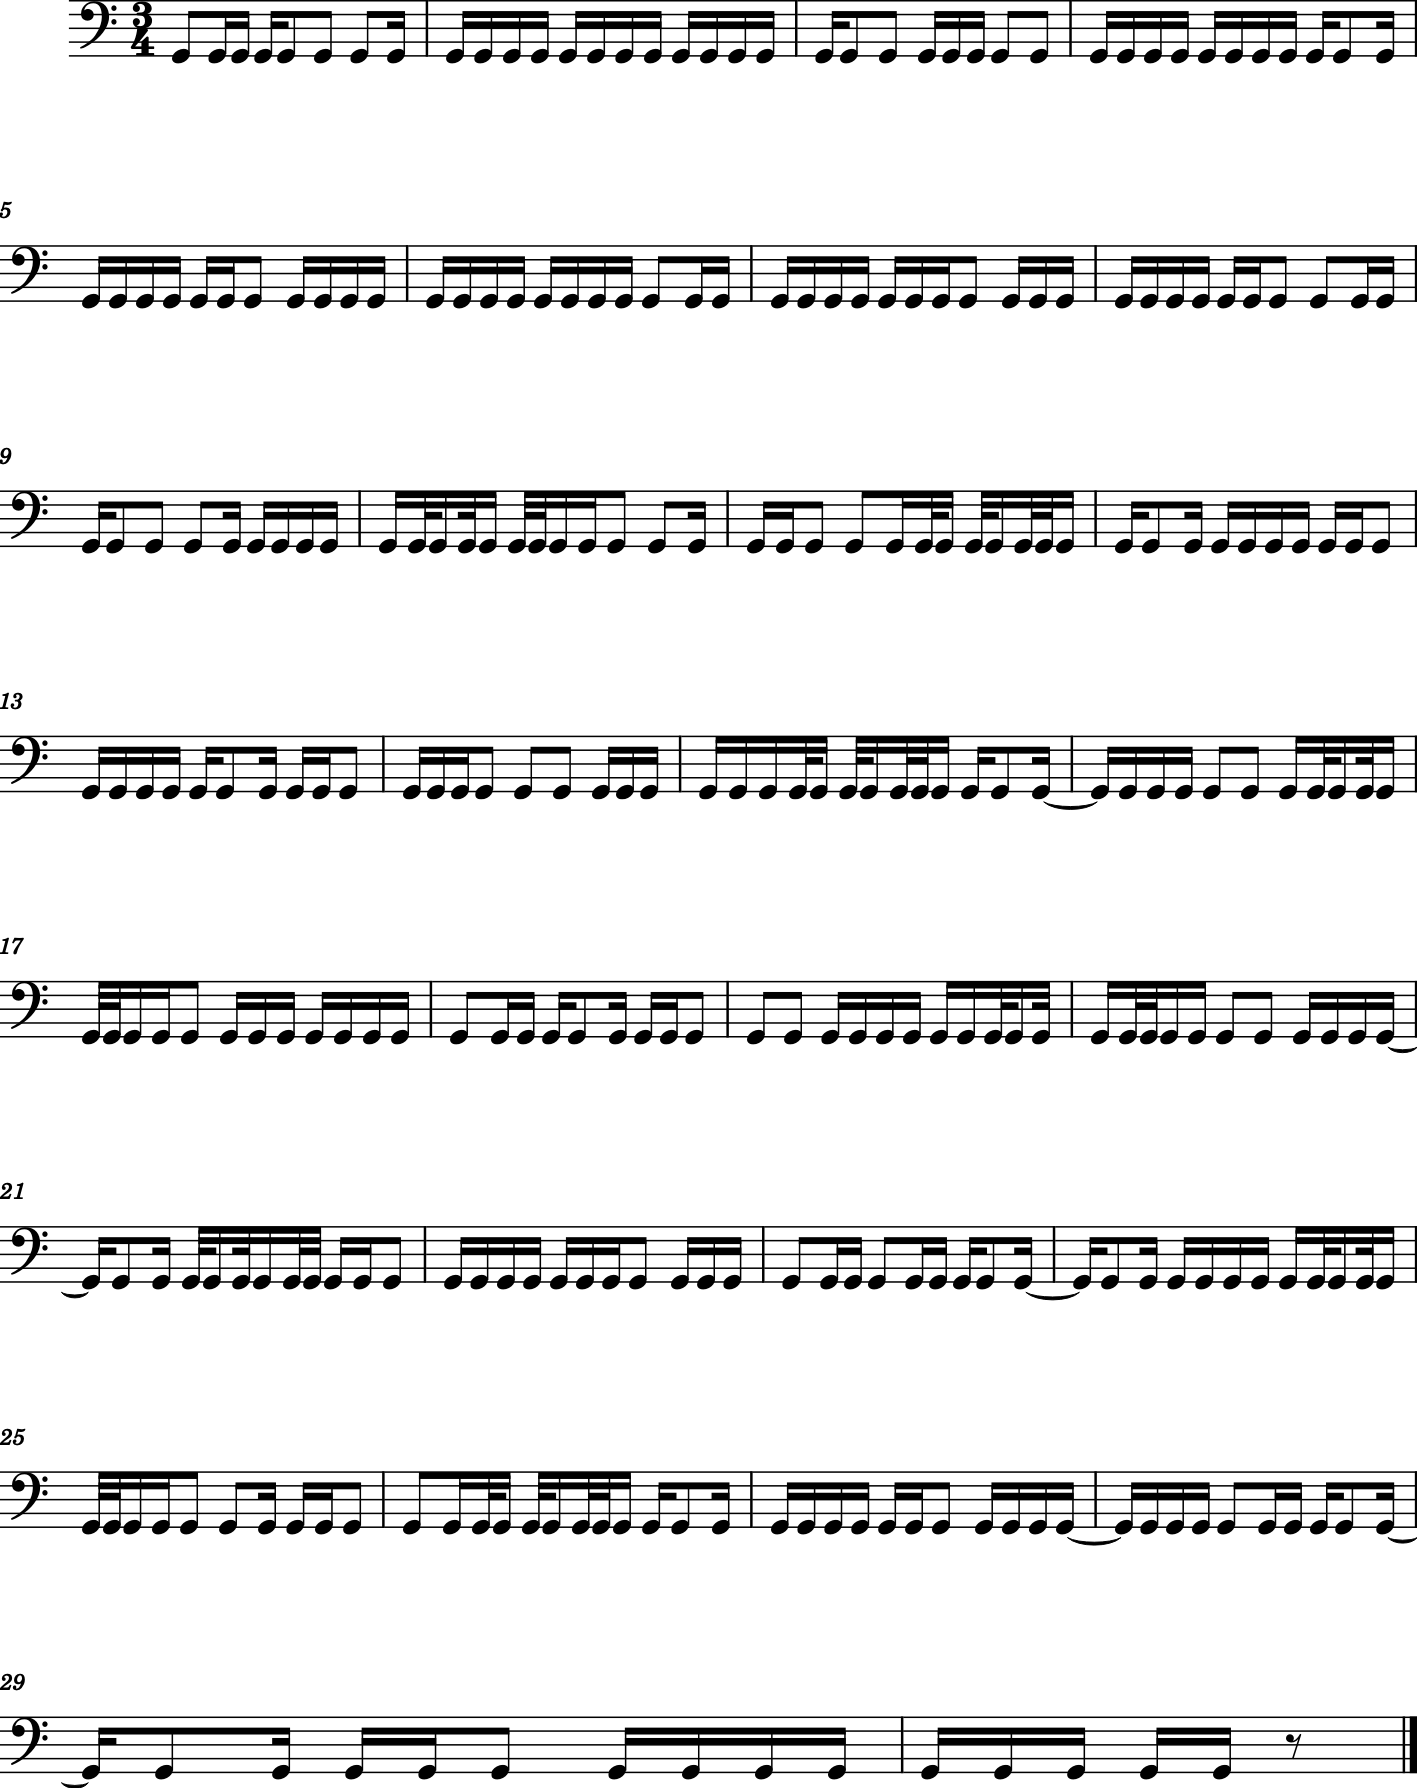

In [15]:
bolero_score.show()

The 32nd notes add some tension and add some irregularity while more and more A, B, and C patterns appear.

In conclusion, in this part, the snare drum pattern has been smoothly reconstructed.

The Finale will differ significantly from what was exposed in Milestone 1 in style and means, but not in goal. The objective remains bringing this narrative story to a close melodically. Ravel does it in epic tutti fashion while changing the key. Since this piece is essentially a liberal recomposition, we will recreate that our way, by using the harmonization tool introduced in part 4), only this time, the rhythms are handwritten.

This concludes our deep dive on the methods used to encompass the narrative scheme presented in Milestone 1, along with its study of chaos and convergence.

# III) Outlook

Here is a rough timeline of the piece so far:
INSERT TIMELINE

What remains to be done are essentially some transitions. The precise details for transitioning have already been presented in the sub-structures development above. We will also smooth some edges, try out different possibilities for the non-deterministic parts of the composition, and select the ones we see fit.